In this tutorial, you will customize a `pre-trained` model with `feature extraction` and `fine-tune`.

In [0]:
# !pip install -q tf-nightly

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200206
GPU is available.


# Data Preprocessing

## Download Datasets

Here we are going to use the `cats_vs_dogs` datasets via `tfds.load()` method. However, the dataset didn't be split before so we have to split the dataset into three subsets.

In [0]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
  name="cats_vs_dogs", 
  split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
  with_info=True, 
  as_supervised=True)

In [4]:
raw_train, metadata

(<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 tfds.core.DatasetInfo(
     name='cats_vs_dogs',
     version=4.0.0,
     description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
     homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
     features=FeaturesDict({
         'image': Image(shape=(None, None, 3), dtype=tf.uint8),
         'image/filename': Text(shape=(), dtype=tf.string),
         'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
     }),
     total_num_examples=23262,
     splits={
         'train': 23262,
     },
     supervised_keys=('image', 'label'),
     citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
     author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
     title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
     boo

In [5]:
# a method
get_label_name = metadata.features['label'].int2str
get_label_name

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=2)>

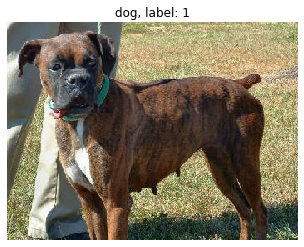

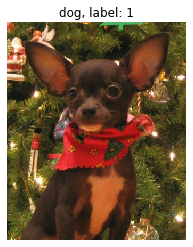

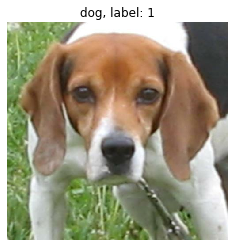

In [6]:
for image, label in raw_train.take(3):
  plt.imshow(image)
  plt.title(get_label_name(label) + ", label: {}".format(label))
  plt.axis("off")
  plt.show()

## Data Generators

In [0]:
IMG_SIZE = 160

def resize_normalize(image, label):
  img = tf.cast(image, tf.float32)
  img = tf.image.resize(img, size=(IMG_SIZE, IMG_SIZE))
  img = (img / 127.5) - 1.0
  return img, label

Apply the preprocessing function to the datasets.

In [0]:
train = raw_train.map(resize_normalize)
validation = raw_validation.map(resize_normalize)
test = raw_test.map(resize_normalize)

Shuffle and batch the datasets.

In [0]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [0]:
train_batches = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Inspect the train dataset.

In [11]:
for batch_imgs, batch_labels in train_batches.take(1):
  print(batch_imgs.shape, batch_labels.shape)
  print("Batch Data: {}".format(batch_labels))

(32, 160, 160, 3) (32,)
Batch Data: [1 0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1]


# Create the Base Model From a Pre-Trained Model

Here we create a base model from a pretrained model named MobileNetV2, which was created by Google and was trained on a large image dataset ImageNets.

First, you need to decide which layer of MobileNetV2 is used for feature extraction. The very last layer or the top layer of the MobileNetV2 is the classification layer, which outputs the probabilities of 1000 categories. We don't need the very last layer, instead, we need the feature extraction layer which is the previous one before the classification layer, or more specifically, the layer before the flatten operation. This layer is also called the `bottleneck layer`.

In `TF.keras`, you can simply load the model without the classification layers using a parameter `include_top` which is set to `False` if you don't want to load the final layer.

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# load the pre-trained model MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
  input_shape=IMG_SHAPE, 
  include_top=False, 
  weights='imagenet')

Such a feature extraction layer converts each `160x160x3` image into a `5x5x1280` block of features.

In [13]:
feature_batch = base_model(batch_imgs)
feature_batch.shape

TensorShape([32, 5, 5, 1280])

# Feature Extraction

## Freeze the Convolutional Base

You can freeze the model (not to train it) and extract the features using it.

In [0]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

## Add a Classification Layer

To generate a prediction from a block of features, you can average over the spatial `5x5` locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features into a 1280-size vector.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 1280])

Here the activation function could not be set, the result is the logit number which is positive for class 1 and negative for class 2.

In [17]:
prediction_layer = tf.keras.layers.Dense(units=1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

TensorShape([32, 1])

Stack the partial network into a bigger one.

In [18]:
def build_model(inputs):
  fe = base_model(inputs)
  gv = global_average_layer(fe)
  new_cls_res = prediction_layer(gv)
  return new_cls_res

inputs = tf.keras.Input(shape=IMG_SHAPE)
outputs = build_model(inputs)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


Only 1281 variables are available for training and the main architecture body 2.5M ones are frozen.

In [19]:
len(model.trainable_variables)

2

In [20]:
for v in model.trainable_variables:
  print(v.name)

dense/kernel:0
dense/bias:0


As you see, the trainable variables are only related to the final dense layer.

## Compile the Model

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## Train the Model

In [22]:
history = model.fit(train_batches, epochs=10, validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 45s 78ms/step - loss: 0.4381 - binary_accuracy: 0.7684 - val_loss: 0.2082 - val_binary_accuracy: 0.8745
Epoch 2/10
582/582 [==============================] - 42s 72ms/step - loss: 0.2312 - binary_accuracy: 0.9020 - val_loss: 0.1588 - val_binary_accuracy: 0.9080
Epoch 3/10
582/582 [==============================] - 42s 72ms/step - loss: 0.1830 - binary_accuracy: 0.9228 - val_loss: 0.1365 - val_binary_accuracy: 0.9196
Epoch 4/10
582/582 [==============================] - 42s 72ms/step - loss: 0.1604 - binary_accuracy: 0.9353 - val_loss: 0.1210 - val_binary_accuracy: 0.9295
Epoch 5/10
582/582 [==============================] - 42s 73ms/step - loss: 0.1475 - binary_accuracy: 0.9384 - val_loss: 0.1178 - val_binary_accuracy: 0.9334
Epoch 6/10
582/582 [==============================] - 42s 72ms/step - loss: 0.1371 - binary_accuracy: 0.9435 - val_loss: 0.1119 - val_binary_accuracy: 0.9368
Epoch 7/10
582/582 [==============================] 

In [23]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

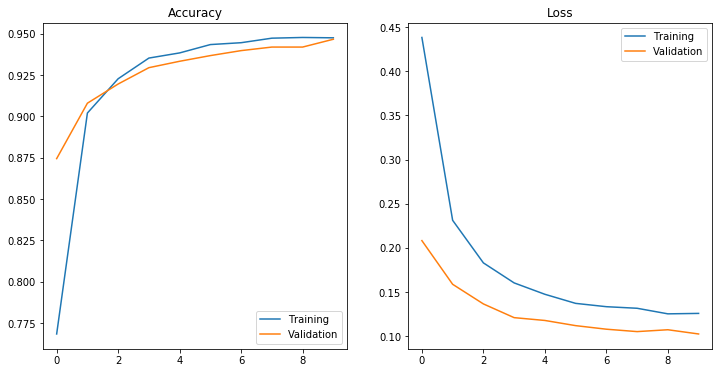

In [35]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label="Training")
plt.plot(history.history['val_binary_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend(loc="upper right")

plt.show()

# Fine Tuning

In the previous training, adding a classifier layer on the top of a base model and then train the model only on the newly added layer. Such training can't update the weights of the base model. However, the performance of the model can be further improved when training the base model. Next, we are going to train the whole model include the newly added layer on the specific dataset. Such an operation is called fine-tune. But remember fine-tuning must be after the previous job, which training the newly added layer is finished, otherwise, the gradient would be influenced too much in the pretrained base model. It might lose the generalization ability of the base model.

In general, the fine-tuning is only available for the last several layers. The higher layer goes, it learns from more specific to the purpose. On the contrary, the lower layer is much generalized for any kind of task.

In [25]:
base_model.trainable = True

# look at how many layers in the base model
print("Number of Layers in the base model: {}.".format(len(base_model.layers)))

# fine-tune from this layers
fine_tune_at = 100

# freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of Layers in the base model: 155.


## Compile and Train the Model

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [27]:
len(model.trainable_variables)

58

As you see, the trainable variables are increasing.

In [28]:
history_fine = model.fit(train_batches, epochs=20, 
                         initial_epoch=history.epoch[-1], 
                         validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 47s 80ms/step - loss: 0.0958 - binary_accuracy: 0.9608 - val_loss: 0.0552 - val_binary_accuracy: 0.9772
Epoch 11/20
582/582 [==============================] - 45s 77ms/step - loss: 0.0695 - binary_accuracy: 0.9720 - val_loss: 0.0526 - val_binary_accuracy: 0.9802
Epoch 12/20
582/582 [==============================] - 43s 73ms/step - loss: 0.0529 - binary_accuracy: 0.9789 - val_loss: 0.0536 - val_binary_accuracy: 0.9798
Epoch 13/20
582/582 [==============================] - 43s 73ms/step - loss: 0.0429 - binary_accuracy: 0.9836 - val_loss: 0.0546 - val_binary_accuracy: 0.9794
Epoch 14/20
582/582 [==============================] - 43s 74ms/step - loss: 0.0365 - binary_accuracy: 0.9866 - val_loss: 0.0520 - val_binary_accuracy: 0.9828
Epoch 15/20
582/582 [==============================] - 43s 73ms/step - loss: 0.0256 - binary_accuracy: 0.9912 - val_loss: 0.0539 - val_binary_accuracy: 0.9824
Epoch 16/20
582/582 [=========================

## Visualize the Training

In [29]:
history_fine.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [0]:
acc = history.history['binary_accuracy'] + history_fine.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy'] + history_fine.history['val_binary_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

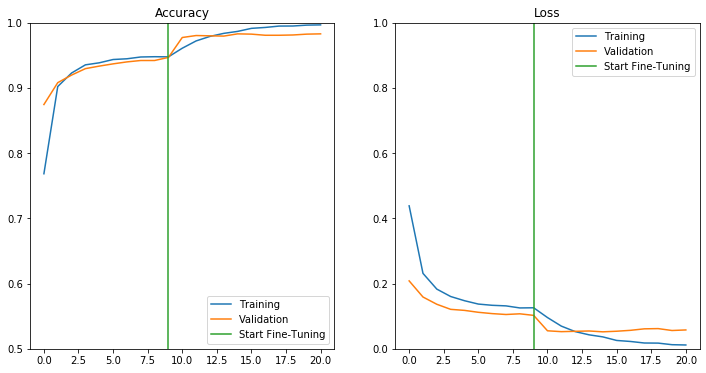

In [36]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(acc, label="Training")
plt.plot(val_acc, label="Validation")
plt.ylim([0.5, 1])
plt.plot([9, 9], plt.ylim(), label='Start Fine-Tuning')
plt.title("Accuracy")
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validation")
plt.ylim([0., 1.])
plt.plot([9, 9], plt.ylim(), label="Start Fine-Tuning")
plt.title("Loss")
plt.legend(loc="upper right")

plt.show()